In [ ]:
# 모듈 호출
import os
import glob
import shutil
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/안봐도보이조_project

/content/drive/MyDrive/안봐도보이조_project


# Image > Numpy Array

In [ ]:
# 경로 내 모든 이미지를 불러와 하나의 numpy array로 만드는 함수 정의

def load_img(path, number_of_data, h_pixel, v_pixel, channel): # 경로, 이미지 총 개수, 가로 픽셀 수, 세로 픽셀 수, 채널 수(흑백/컬러/알파채널여부 등 고려)

  # 이미지 데이터와 라벨 데이터를 담을 matrix 생성
  imgs=np.zeros(number_of_data*h_pixel*v_pixel*channel, dtype=np.uint8).reshape(number_of_data, h_pixel, v_pixel, channel) # 이미지의 데이터는 0~255이기 때문에 데이터타입은 uint8로 지정
  labels=np.zeros(number_of_data,dtype=object) # 라벨로 사용할 고유번호는 최대 90000대이므로 데이터타입 int32

  idx=0 # 순서를 나타낼 인덱스 초기값 지정
  for folder in tqdm(glob.glob(f'{path}/*')):
    for img in glob.glob(f'{folder}/*.jpg'):
      img_array = np.array(Image.open(img),dtype=np.uint8) # 이미지를 어레이로 불러오기
      imgs[idx,:,:,:]=img_array    # 데이터 영역에 이미지 어레이를 복사
      labels[idx]= img.split('/')[-2]  # 상품명을 라벨로 저장
      idx=idx+1 # 순서 +1

  print(f'{number_of_data}개의 이미지 중 {idx}개의 이미지 np.array로 변환 완료')
  return imgs, labels

In [ ]:
path = './train_8' # 작업할 이미지 경로
number_of_data = 0 # 해당 경로 내 총 이미지 수를 담을 변수
for folder in glob.glob(f'{path}/*'):
  number_of_data += len(glob.glob(f'{folder}/*.jpg'))
train_img,train_label = load_img(path, number_of_data, 256, 256, 3) # 이미지 불러오기
np.save('./train_8_img.npy',train_img) # 넘파이 배열 파일로 저장
np.save('./train_8_label.npy',train_label)
print(train_img.shape,train_label.shape) # 결과 확인

100%|██████████| 8/8 [01:51<00:00, 13.90s/it]

8500개의 이미지 중 8500개의 이미지 np.array로 변환 완료
(8500, 256, 256, 3) (8500,)


In [ ]:
path = './valid_8' # 작업할 이미지 경로
number_of_data = 0 # 해당 경로 내 총 이미지 수를 담을 변수
for folder in glob.glob(f'{path}/*'):
  number_of_data += len(glob.glob(f'{folder}/*.jpg'))
valid_img,valid_label = load_img(path, number_of_data, 256, 256, 3) # 이미지 불러오기
np.save('./valid_8_img.npy',valid_img) # 넘파이 배열 파일로 저장
np.save('./valid_8_label.npy',valid_label)
print(valid_img.shape,valid_label.shape) # 결과 확인

100%|██████████| 8/8 [00:11<00:00,  1.43s/it]


1200개의 이미지 중 1200개의 이미지 np.array로 변환 완료
(1200, 256, 256, 3) (1200,)


코카콜라


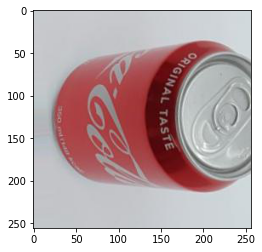

In [ ]:
# 결과 이미지로 확인
img = train_img[133]
plt.imshow(img)
print(train_label[133])

갈아만든배


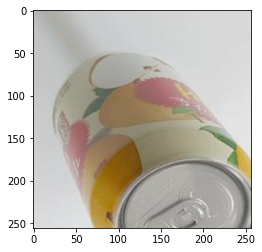

In [ ]:
img = valid_img[133]
plt.imshow(img)
print(valid_label[133])

In [ ]:
del train_img, train_label, valid_img, valid_label # 메모리 용량 확보를 위해 변수 삭제

# Image Scaling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 저장한 이미지 어레이 불러오기
train_img = np.load('./train_8_img.npy')
train_label = np.load('./train_8_label.npy',allow_pickle=True)
valid_img = np.load('./valid_8_img.npy')
valid_label = np.load('./valid_8_label.npy',allow_pickle=True)

In [ ]:
# 스케일링
train_img = train_img/255.0

# 모델링

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255) # 이미 제너레이터로 생성해서 저장했으므로 스케일링만 진행
train_generator = train_datagen.flow_from_directory(
    './train_8',
    batch_size=10,      
    class_mode='categorical', 
    target_size=(128, 128)) 
valid_datagen = ImageDataGenerator(rescale=1./255) # 이미 제너레이터로 생성해서 저장했으므로 스케일링만 진행
valid_generator = train_datagen.flow_from_directory(
    './valid_8',
    batch_size=10,      
    class_mode='categorical', 
    target_size=(128, 128)) 

Found 8500 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.


In [ ]:
print(train_generator.class_indices)

{'갈아만든배': 0, '레쓰비': 1, '밀키스': 2, '스프라이트': 3, '칠성사이다': 4, '코카콜라': 5, '펩시콜라': 6, '환타오렌지': 7}


In [ ]:
print(valid_generator.class_indices)

{'갈아만든배': 0, '레쓰비': 1, '밀키스': 2, '스프라이트': 3, '칠성사이다': 4, '코카콜라': 5, '펩시콜라': 6, '환타오렌지': 7}


In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), padding = 'same', activation = 'relu', input_shape = (128,128,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation = 'relu')) 
model.add(keras.layers.Dense(8, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10) # 10번동안 성능개선이 없으면 학습 조기종료
history = model.fit(train_generator,
                    steps_per_epoch=100, 
                    epochs=10, 
                    validation_data=valid_generator, 
                    validation_steps=20,
                    callbacks=[earlystopping]) 

Epoch 1/10
100/100 [==============================] - 414s 4s/step - loss: 1.6962 - accuracy: 0.2740 - val_loss: 1.3366 - val_accuracy: 0.4850
Epoch 2/10
100/100 [==============================] - 359s 4s/step - loss: 1.2014 - accuracy: 0.4500 - val_loss: 1.0664 - val_accuracy: 0.4850
Epoch 3/10
100/100 [==============================] - 302s 3s/step - loss: 0.6706 - accuracy: 0.7290 - val_loss: 0.3947 - val_accuracy: 0.8700
Epoch 4/10
100/100 [==============================] - 266s 3s/step - loss: 0.4016 - accuracy: 0.8310 - val_loss: 0.4505 - val_accuracy: 0.8500
Epoch 5/10
100/100 [==============================] - 228s 2s/step - loss: 0.2891 - accuracy: 0.8860 - val_loss: 0.2586 - val_accuracy: 0.9050
Epoch 6/10
100/100 [==============================] - 194s 2s/step - loss: 0.2600 - accuracy: 0.9010 - val_loss: 0.2883 - val_accuracy: 0.8900
Epoch 7/10
100/100 [==============================] - 172s 2s/step - loss: 0.2324 - accuracy: 0.9030 - val_loss: 0.1554 - val_accuracy: 0.9250

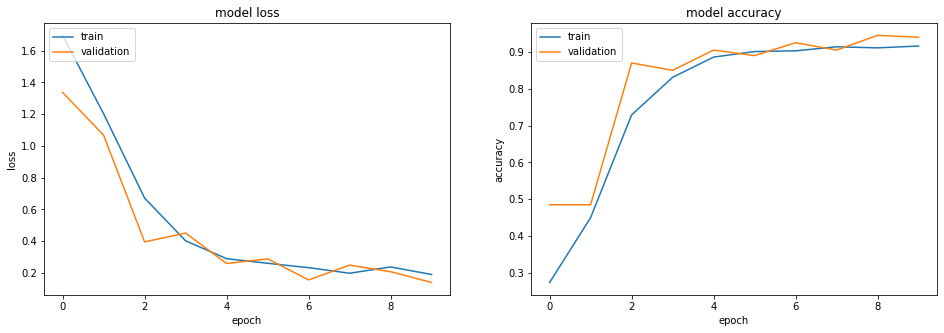

In [ ]:
plt.figure(figsize=(16,5))

# 만들어진 모델에 대해 train dataset과 validation dataset의 loss 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [ ]:
model.save('8_class_model.h5')

In [ ]:
test_img = cv2.imread('./2205722_1.jpg')
test_img = cv2.resize(test_img,(128,128))/255
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)

array([[1.6340387e-07, 7.8246671e-23, 0.0000000e+00, 7.2735387e-27,
        0.0000000e+00, 5.6910939e-12, 2.4373948e-23, 9.9999988e-01]],
      dtype=float32)

In [ ]:
test_img = cv2.imread('./train_8/펩시콜라/40033_1.jpg')
test_img = cv2.resize(test_img,(128,128))/255
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)

array([[4.0927524e-05, 1.6550149e-12, 5.4828980e-21, 4.6388623e-15,
        6.7466557e-20, 1.6815231e-05, 5.9765151e-11, 9.9994230e-01]],
      dtype=float32)

In [ ]:
test_img = cv2.imread('./11.jpg')
test_img = cv2.resize(test_img,(128,128))/255
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)

array([[4.6775480e-13, 9.9964023e-01, 5.5402503e-13, 1.2498013e-12,
        1.9131510e-10, 5.8553169e-11, 3.5975358e-04, 3.1092815e-09]],
      dtype=float32)

In [ ]:
test_img = cv2.imread('./train_8/환타오렌지/10052_29.jpg')
test_img = cv2.resize(test_img,(128,128))/255
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)

array([[9.6325579e-09, 9.9281001e-01, 4.9082065e-13, 5.3187083e-10,
        7.8098944e-10, 3.4955036e-08, 7.1817371e-03, 8.2946317e-06]],
      dtype=float32)

In [ ]:
test_img = cv2.imread('./train_8/갈아만든배/10014_.jpg')
test_img = cv2.resize(test_img,(128,128))/255
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)

array([[2.6997512e-05, 9.7312498e-01, 4.4729328e-04, 4.6506108e-04,
        1.2555273e-03, 5.5692162e-06, 2.4591973e-02, 8.2480277e-05]],
      dtype=float32)